In [115]:
import pycolmap
import os
import cv2
import numpy as np
import open3d as o3d
import logging
from logging import info, debug, warn, error

In [116]:
logging.basicConfig(level=logging.INFO)

In [117]:
reconstruction = pycolmap.Reconstruction("../data/alameda/colmap/sparse/0")
print(reconstruction.summary())
info(f"Loaded reconstruction")

Reconstruction:
	num_reg_images = 1734
	num_cameras = 1
	num_points3D = 347315
	num_observations = 2573099
	mean_track_length = 7.40855
	mean_observations_per_image = 1483.91
	mean_reprojection_error = 0.559822


INFO:root:Loaded reconstruction


In [118]:
points = np.array([point.xyz for point in reconstruction.points3D.values()])
colors = np.array([point.color for point in reconstruction.points3D.values()]) / 255  # Normalize RGB

In [119]:
#!export LIBGL_DRIVERS_PATH=/usr/lib/x86_64-linux-gnu/dri

In [120]:
# Create point cloud
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)
point_cloud.colors = o3d.utility.Vector3dVector(colors)

# Visualize
#o3d.visualization.draw_geometries([point_cloud])

In [121]:
def project_to_img(reconstruction, image, cam_from_world):
    # Camera parameters
    camera = reconstruction.cameras[image.camera_id]
    K = np.array([
        [camera.focal_length_x, 0, camera.principal_point_x],
        [0, camera.focal_length_y, camera.principal_point_y],
        [0, 0, 1]
    ])

    # Rotation and translation
    extrinsic_matrix = cam_from_world.matrix()
    R_matrix = extrinsic_matrix[:, :3]
    T = extrinsic_matrix[:, 3]
    # Convert rotation matrix to rotation vector
    R = cv2.Rodrigues(R_matrix)[0]

    # Collect 3D points visible in the current image
    visible_points3D = []
    for point_id, point in reconstruction.points3D.items():
        if any(element.image_id == image.image_id for element in point.track.elements):
            visible_points3D.append(point.xyz)
    points3D = np.array(visible_points3D)

    # Handle cases with no visible points
    if points3D.size == 0:
        return np.empty((0, 2))

    # Project 3D points to 2D image plane
    points2D = cv2.projectPoints(points3D, R, T, K, None)[0]

    return points2D
    

In [125]:
def density_map(points2D, image_shape, sigma=10):
    """
    Create a density map from projected 2D points with Gaussian smoothing.
    
    Args:
        points2D (np.ndarray): Array of 2D points (N, 1, 2) format from cv2.projectPoints.
        image_shape (tuple): Shape of the density map (height, width).
        sigma (int): Standard deviation for Gaussian blur.
        
    Returns:
        np.ndarray: Smoothed density map.
    """
    height, width = image_shape[:2]
    density_map = np.zeros((height, width), dtype=np.float32)

    # Populate the density map with the projected points
    for point in points2D:
        x, y = int(point[0][0]), int(point[0][1])
        if 0 <= x < width and 0 <= y < height:
            density_map[y, x] += 1 

    # Apply Gaussian blur using OpenCV
    ksize = int(6 * sigma + 1)
    smoothed_density_map = cv2.GaussianBlur(density_map, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)

    return smoothed_density_map

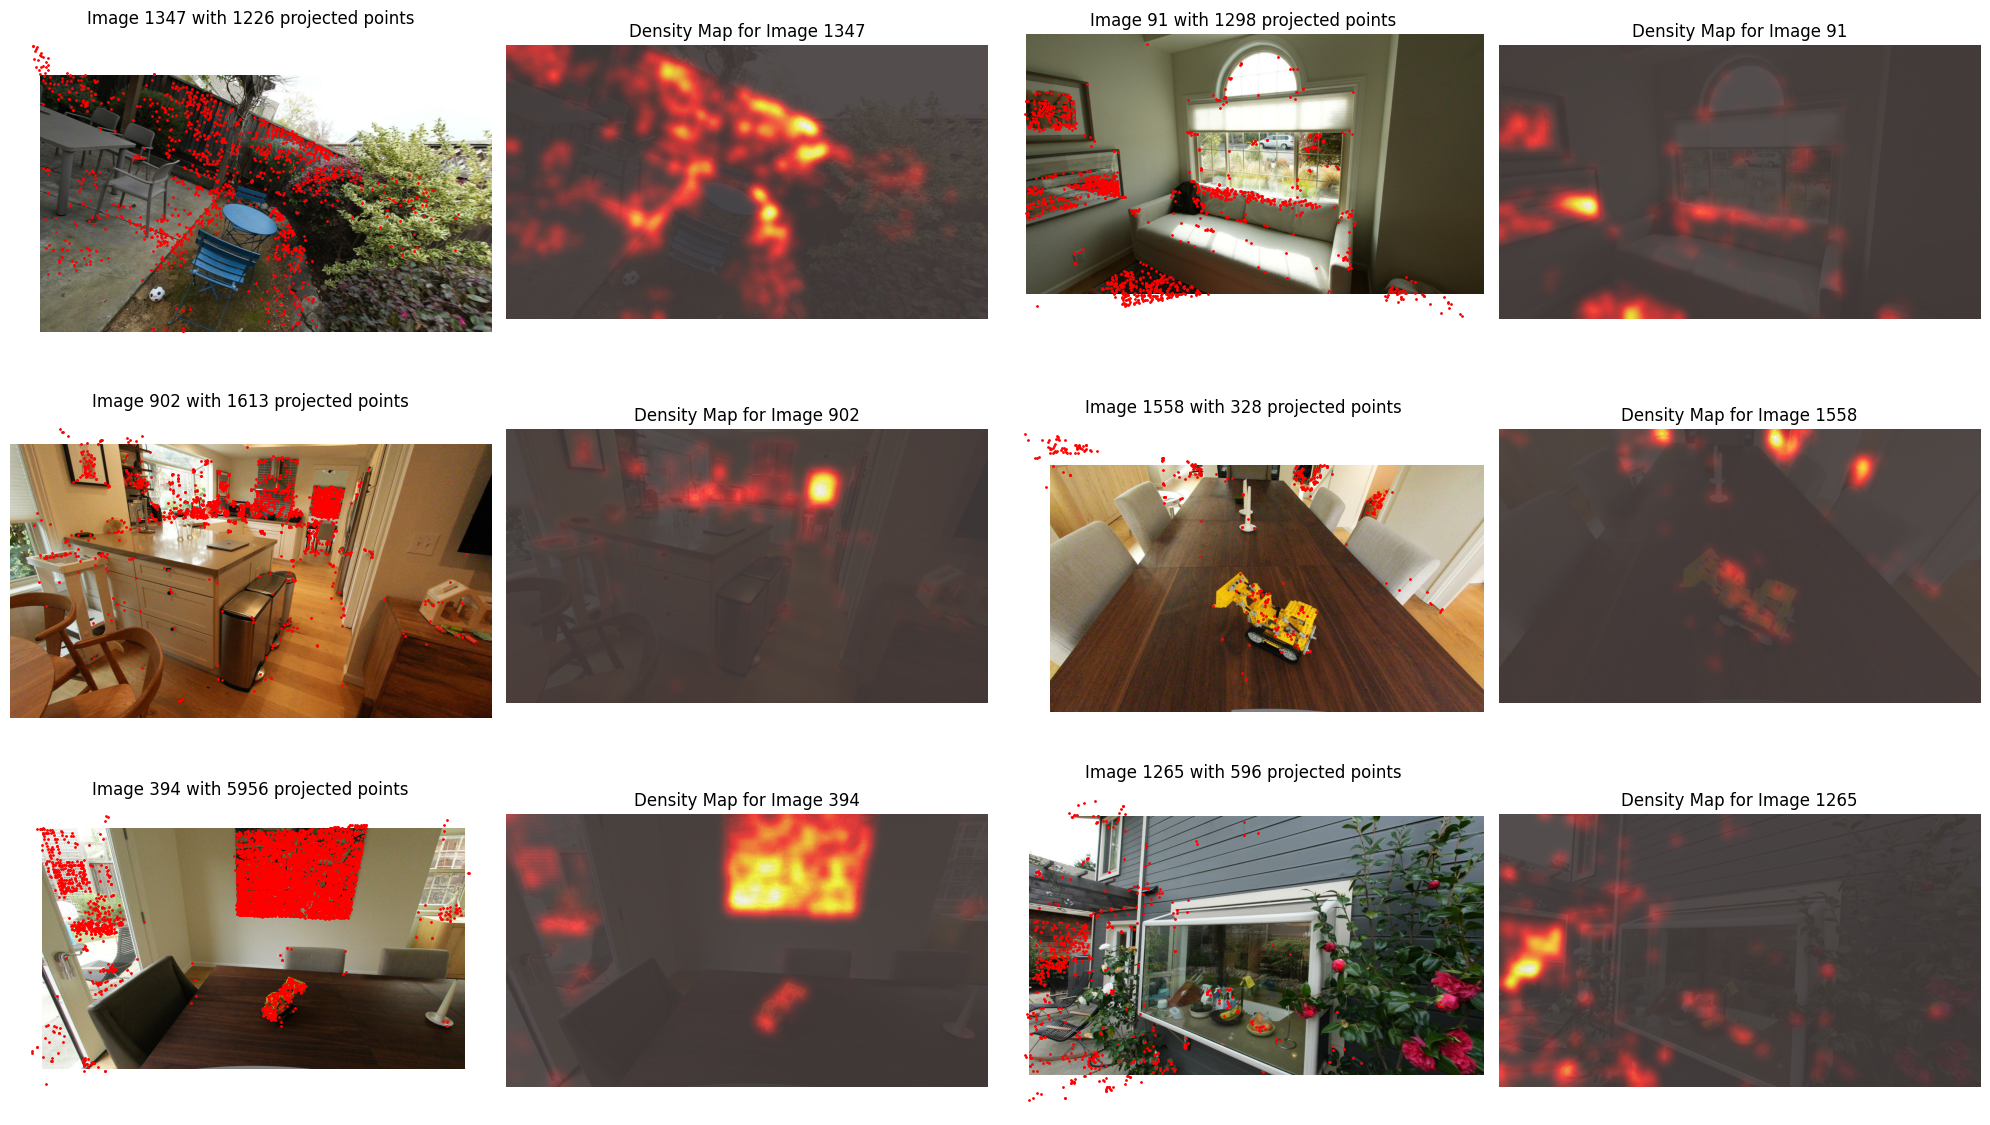

In [129]:
import random
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

# Ensure that `project_to_img` and `density_map` functions are defined as per the previous code.

# Select six random images
random_images = random.sample(list(reconstruction.images.values()), 6)

# Create a figure with subplots (3 rows, 4 columns) to display images and density maps side-by-side
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

for i, image in enumerate(random_images):
    # Project 3D points to 2D for this image
    points2D = project_to_img(reconstruction, image, image.cam_from_world)
    
    # Load the original image
    original = cv2.imread(os.path.join("../data/alameda/images", image.name))
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Generate the density map for the projected points
    height, width = original.shape[:2]
    smoothed_density_map = density_map(points2D, (height, width), sigma=30)

    # Display the original image with projected points
    ax_img = axes[i // 2, (i % 2) * 2]
    ax_img.imshow(original_rgb)
    if points2D.size > 0:
        ax_img.scatter(points2D[:, 0, 0], points2D[:, 0, 1], c='r', s=1)  # Overlay points
    ax_img.set_title(f"Image {image.image_id} with {points2D.shape[0]} projected points")
    ax_img.axis('off')

    # Display the density map
    ax_density = axes[i // 2, (i % 2) * 2 + 1]
    ax_density.imshow(original_rgb, alpha=0.3)
    ax_density.imshow(smoothed_density_map, cmap='hot', alpha=0.7)  # Overlay density map
    ax_density.set_title(f"Density Map for Image {image.image_id}")
    ax_density.axis('off')

plt.tight_layout()
plt.show()


In [132]:
# Statistics
import pandas as pd
import numpy as np
import random
import tqdm

# Define the density threshold
density_threshold = 0.5

# Prepare a list to store results
results = []

# Iterate over all training images
for image in tqdm.tqdm(reconstruction.images.values()):
    # Project 3D points onto the 2D image plane
    points2D = project_to_img(reconstruction, image, image.cam_from_world)
    
    # Load the original image to get its dimensions
    original = cv2.imread(os.path.join("../data/alameda/images", image.name))
    height, width = original.shape[:2]

    # Generate the density map for the projected points
    smoothed_density_map = density_map(points2D, (height, width), sigma=10)

    # Calculate the fraction of the image area with density above the threshold
    high_density_area = np.sum(smoothed_density_map > density_threshold)
    total_area = height * width
    fraction_high_density = high_density_area / total_area

    # Store the results for this image
    results.append({
        "image_id": image.image_id,
        "num_projected_points": points2D.shape[0],
        "fraction_high_density_area": fraction_high_density
    })

# Create a DataFrame from the results
df = pd.DataFrame(results)
print(df)

# Save the DataFrame to a CSV file
df.to_csv("density_results.csv", index=False)


  2%|▏         | 28/1734 [00:59<1:00:12,  2.12s/it]


KeyboardInterrupt: 